In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt

import pandas as pd

In [2]:
churn_data = pd.read_csv('https://raw.githubusercontent.com/'
                         'treselle-systems/customer_churn_analysis/'
                         'master/WA_Fn-UseC_-Telco-Customer-Churn.csv')
churn_data.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [3]:
churn_data = churn_data.set_index('customerID')
churn_data = churn_data.drop(['TotalCharges'], axis=1)

# The dataset is naturally heirarchical: some columns only apply to some users. Ex, if you don't have internet 
# then the column OnlineBackup isn't applicable, as it's value is "No internet service". We 
# are going to map this back to No. We will treat the hierachical nature by stratifying on the 
# different services a user may have. 
churn_data = churn_data.applymap(lambda x: "No" if str(x).startswith("No ") else x)

strata_cols = ['InternetService', 'StreamingMovies', 'StreamingTV', 'PhoneService']

df = pd.get_dummies(churn_data, 
                    columns=churn_data.columns.difference(strata_cols + ['tenure', 'MonthlyCharges']), 
                    drop_first=True)

In [4]:
from lifelines import CoxPHFitter

cph = CoxPHFitter().fit(df, 'tenure', 'Churn_Yes', strata=strata_cols)

In [5]:
cph

<lifelines.CoxPHFitter: fitted with 7043 observations, 5174 censored>

In [17]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 observations, 5174 censored>
      duration col = 'tenure'
         event col = 'Churn_Yes'
            strata = ['InternetService', 'StreamingMovies', 'StreamingTV', 'PhoneService']
number of subjects = 7043
  number of events = 1869
    log-likelihood = -10106.05
  time fit was run = 2019-05-01 18:48:41 UTC

---
                                       coef exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
3                                                                                                              
MonthlyCharges                        -0.01      0.99      0.02  -0.24   0.81      0.31       -0.05        0.04
Contract_One year                     -1.59      0.20      0.09 -17.82 <0.005    233.65       -1.77       -1.42
Contract_Two year                     -3.11      0.04      0.17 -18.00 <0.005    238.16       -3.45       -2.77
Dependents_Yes                        -0.05      0.95      0.07  -0.67   0.50      

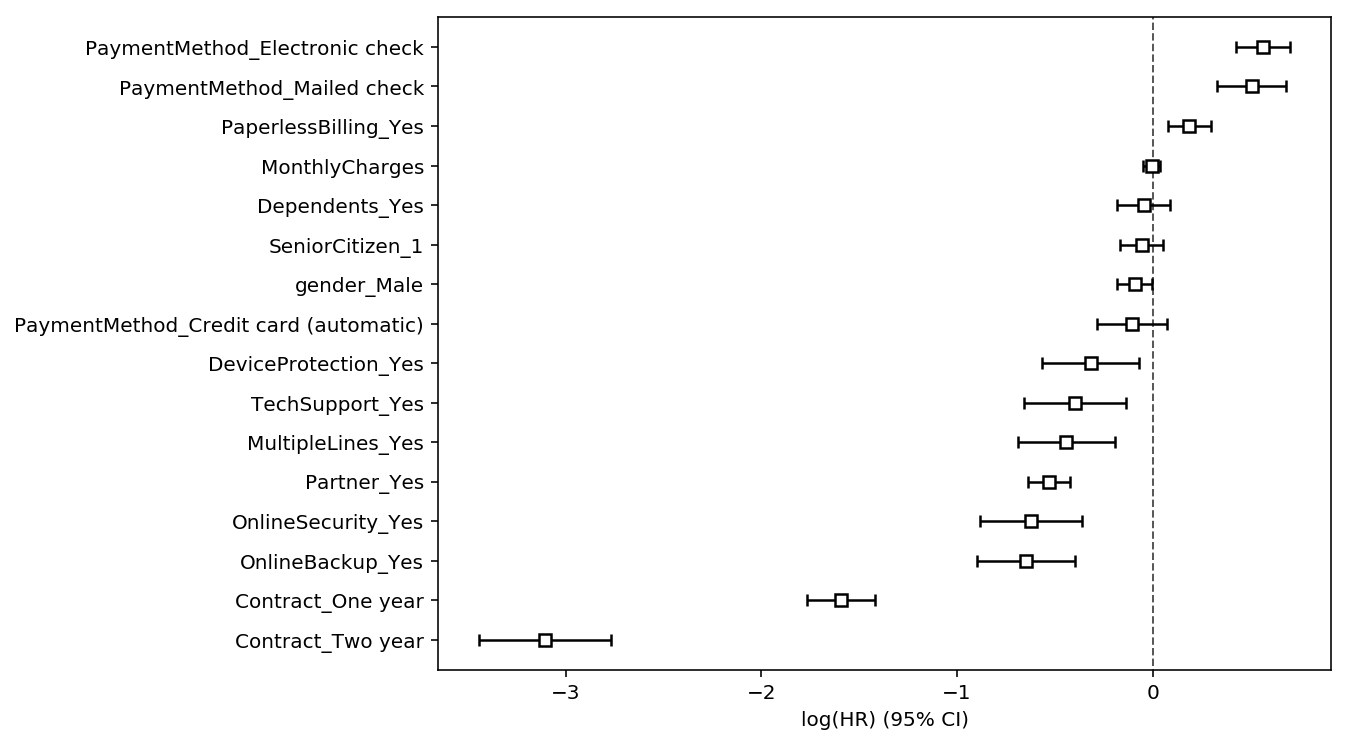

In [18]:
ax = plt.subplots(figsize=(8, 6))
cph.plot(ax=ax[1])

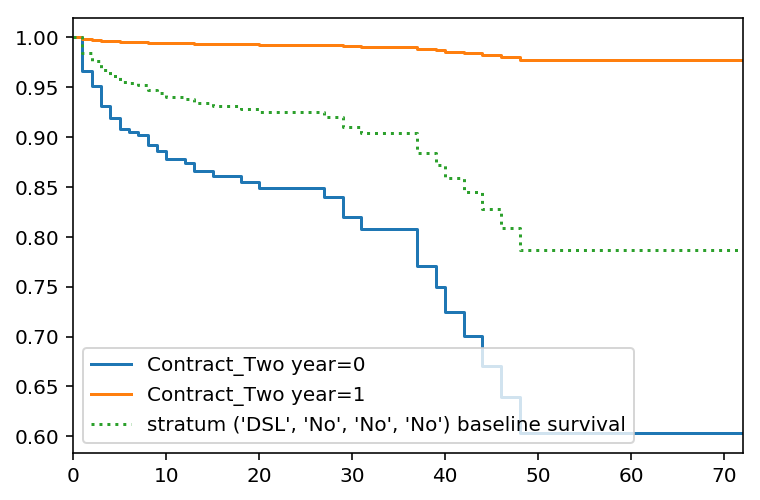

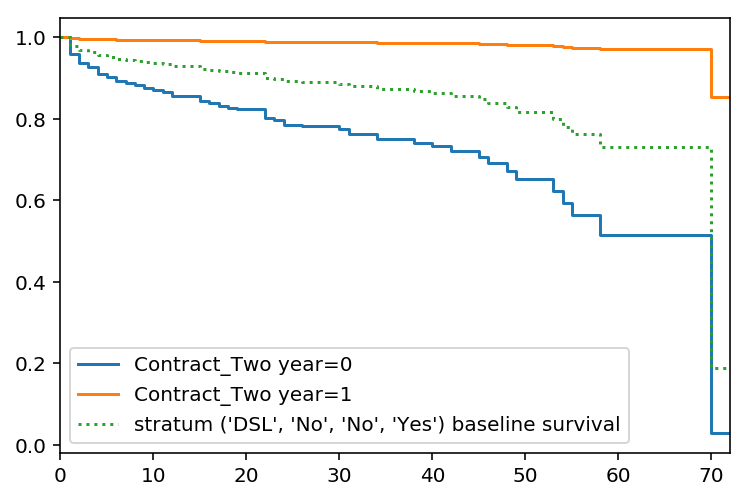

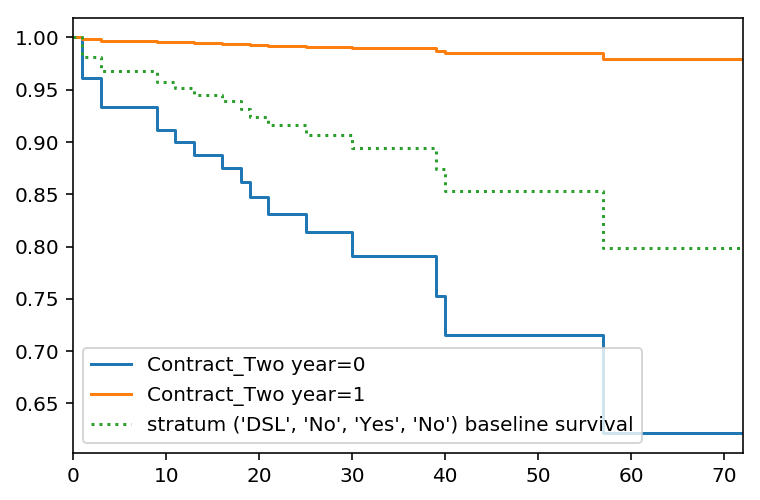

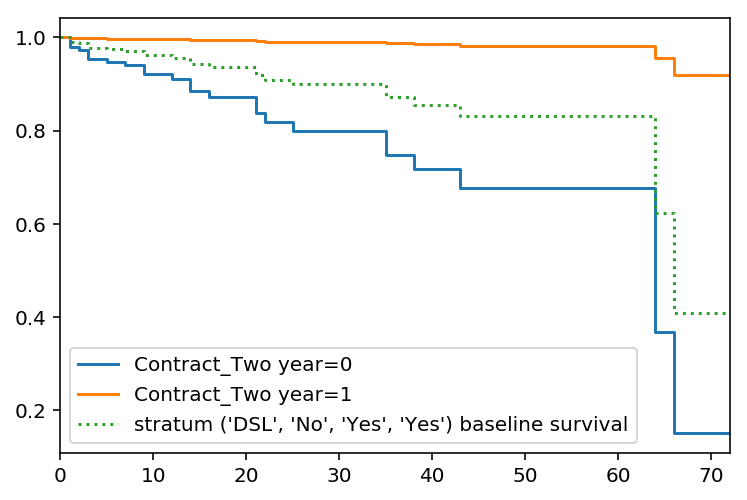

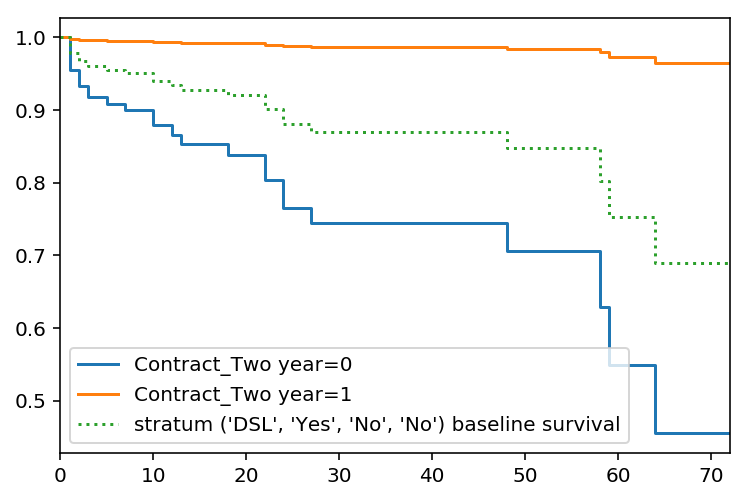

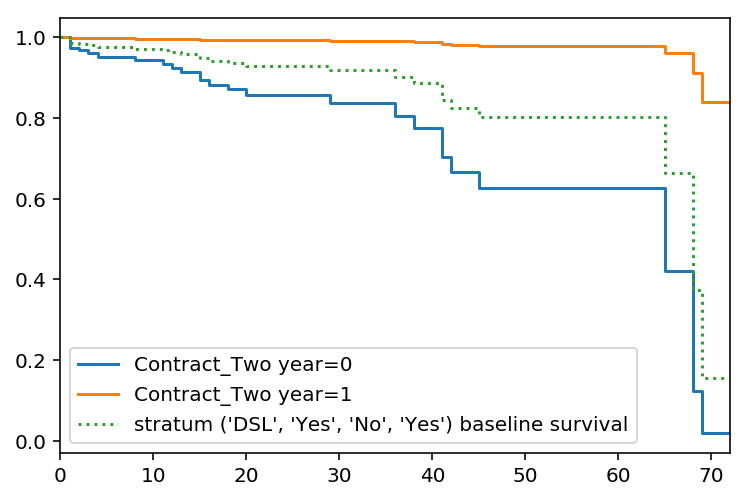

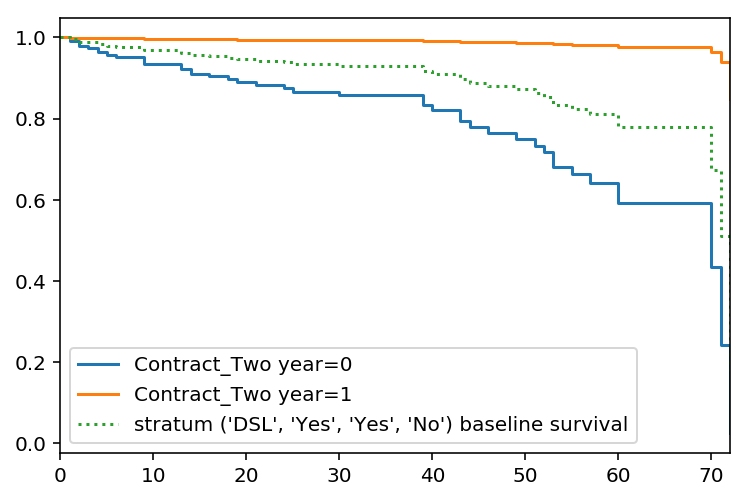

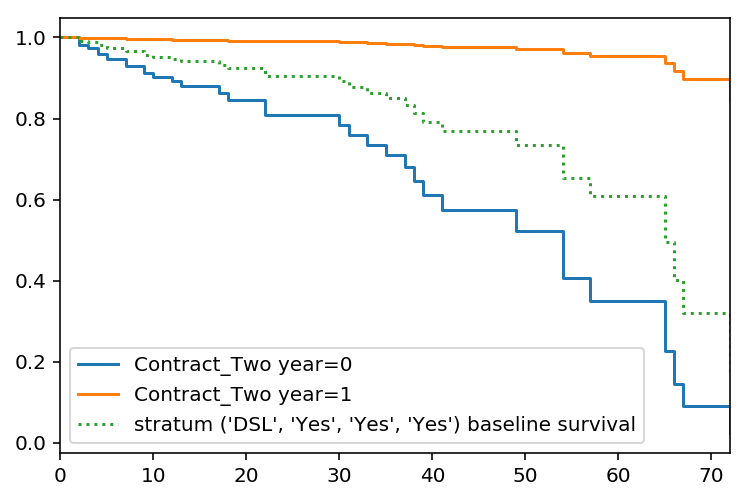

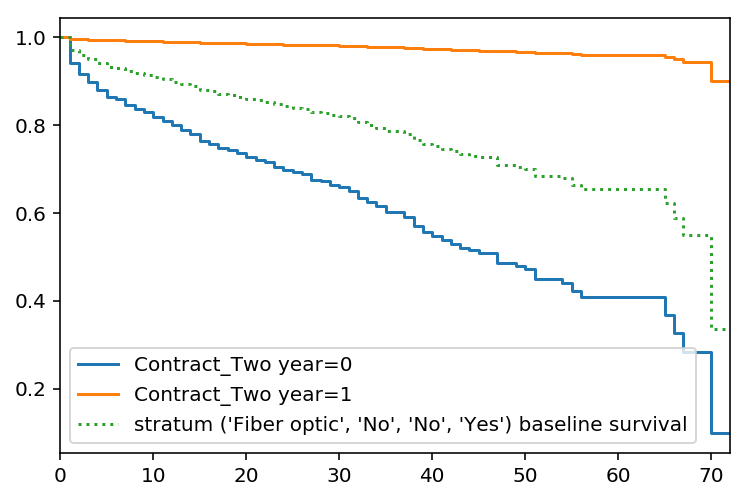

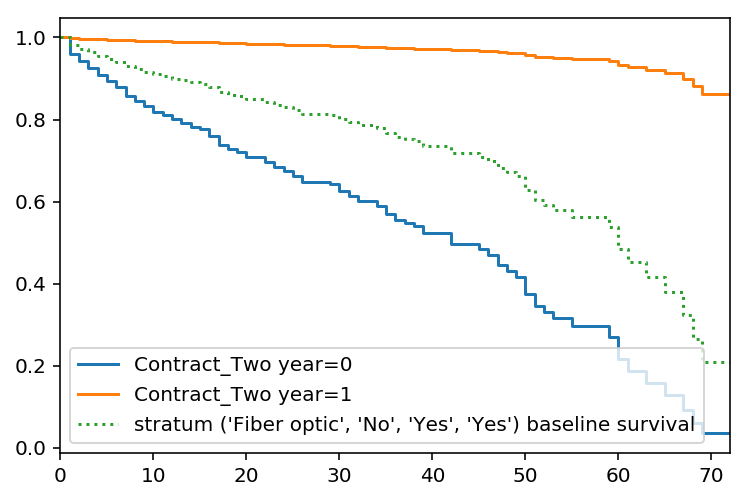

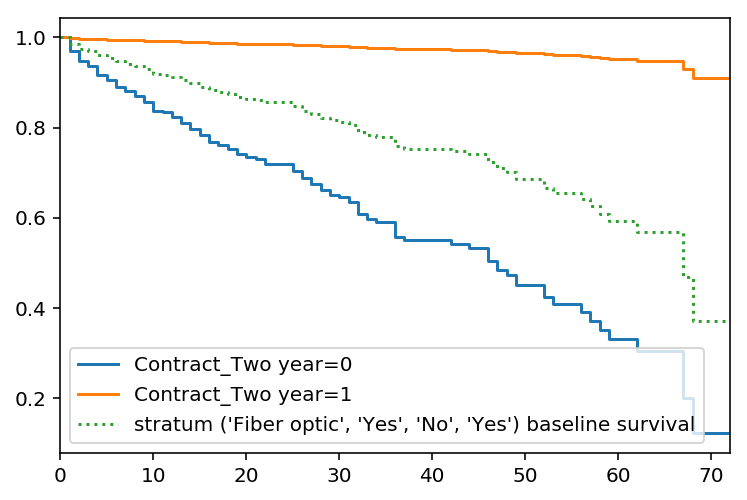

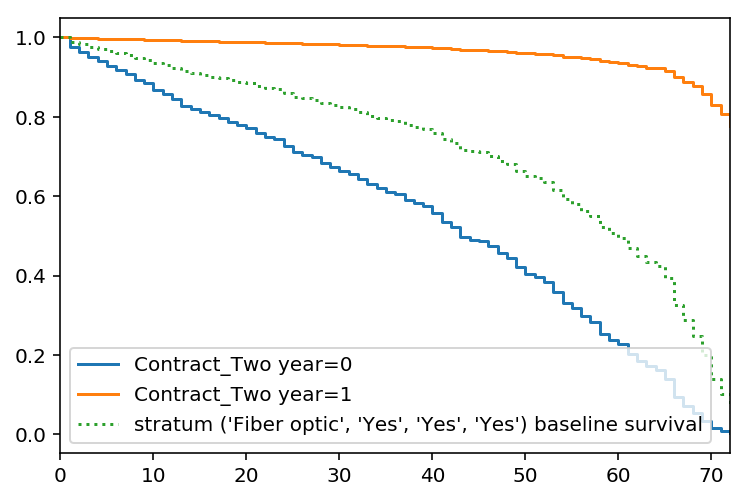

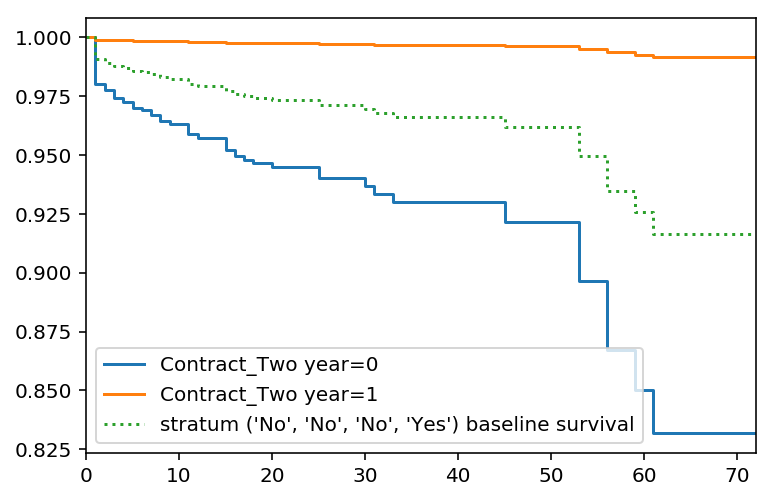

In [19]:
cph.plot_covariate_groups('Contract_Two year', values=[0, 1]);